# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [31]:
# импорт библиотек
import pandas as pd
import numpy as np
import random
import sys

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [32]:
# скачиваем данные 
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-26 16:11:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  55.4MB/s    in 4.0s    

2021-10-26 16:11:38 (50.8 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [33]:
# считываем данные
df = pd.read_csv('data.txt.zip', header=None)
# выводим первые записи посмотреть структуру данных
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [34]:
# делим вручную на train и test
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [35]:
# функция фиксации seed для random
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

RMSE:  9.51016306843388


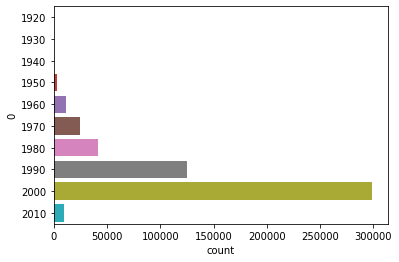

In [36]:
# фиксируем random seed
set_random_seed(192)

# нормализуем входные данные
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# создаем объект ridge регрессии
clf = Ridge()

# обучаем
clf.fit(X_train, y_train)

# предсказываем на тестовой выборке
y_pred = clf.predict(X_test)

# считаем качество RMSE
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

# выведем график распределения количества песен в в зависимости от десятилетия (взят с kaggle)
data_ten_year_gap = df[0].apply(lambda year : year-(year%10))
sns.countplot(y=data_ten_year_gap, data=df)

In [37]:
# Посчитаем качество для лучшего константного прогноза
# Для метрики RMSE лучшим константным прогнозом является среднее арифметическое значений целевой переменной
#-------для train---------
const_pred_train = np.mean(y_train)
print(const_pred_train)
y_train_const_array = np.full(train_size, const_pred_train)
print("RMSE train error: ", np.sqrt(mean_squared_error(y_train, y_train_const_array)))
#-------для test---------
const_pred_test = np.mean(y_test)
print(const_pred_test)
y_test_const_array = np.full(y_test.shape[0], const_pred_test)
print("RMSE test error: ", np.sqrt(mean_squared_error(y_test, y_test_const_array)))

1998.3860949074324
RMSE train error:  10.939755150678016
1998.4957582800698
RMSE test error:  10.851909820717683


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

# Источники:
Далее я пользовался частично кодом с сайтов, а также некоторыми функциями с семинаров.

#https://qudata.com/ml/ru/NN_Base_Torch_NN.html
#https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93

In [38]:
# нормализуем также выходы относительно максимального значения выхода (видимо относительно 2011 года)
y_scaler = max(y)
y_train = y_train / y_scaler
y_test = y_test / y_scaler

In [39]:
# класс для подготовки датасета 
class RegressionDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [40]:
# задаем константы 
batch_size = 64
epoches = 5
learning_rate = 0.001

# делаем наборы данных
train_set = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_set = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

# загружаем в dataloader
train_loader = DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    shuffle=True
    )
test_loader = DataLoader(
    dataset=test_set, 
    batch_size=batch_size,
    shuffle=False
    )

In [42]:
# функция отрисовки графика истории обучения (из ноутбука одного из семинаров)
def plot_history(history, name, title="loss"):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(history, label="{}".format(name), zorder=1)
    plt.xlabel("Steps")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [43]:
# задаем класс нейронной сети, прописываем ее архитектуру  
class MultipleRegression(nn.Module):
    def __init__(self):
      set_random_seed(192)
      super(MultipleRegression, self).__init__()
      # num_features - 90
      self.relu = nn.LeakyReLU()
      self.dropout_1 = nn.Dropout(0.15)
      self.dropout_2 = nn.Dropout(0.15)
      self.layer_1_bn=nn.BatchNorm1d(128)
      self.layer_2_bn=nn.BatchNorm1d(16)
      self.layer_1 = nn.Linear(90, 128)
      self.layer_2 = nn.Linear(128, 16)
      self.layer_out = nn.Linear(16, 1)


    def forward(self, inputs):
      x = self.relu(self.layer_1_bn(self.layer_1(inputs)))
      x = self.dropout_1(x)
      x = self.relu(self.layer_2_bn(self.layer_2(x)))
      x = self.dropout_2(x)
      x = self.layer_out(x)
      return (x)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultipleRegression()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()
# неудачные пробы различных оптимизаторов
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.89, weight_decay=1e-4)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

Training started


  3%|▎         | 1/30 [00:23<11:09, 23.09s/it]

Train loss: 445.64082849025726


  7%|▋         | 2/30 [00:46<10:53, 23.35s/it]

Train loss: 62.42574723996222


 10%|█         | 3/30 [01:09<10:27, 23.24s/it]

Train loss: 9.913890646770597


 13%|█▎        | 4/30 [01:33<10:10, 23.48s/it]

Train loss: 9.185323444195092


 17%|█▋        | 5/30 [01:58<09:57, 23.88s/it]

Train loss: 8.994259665254503


 20%|██        | 6/30 [02:22<09:37, 24.05s/it]

Train loss: 8.920016444753855


 23%|██▎       | 7/30 [02:47<09:16, 24.20s/it]

Train loss: 8.886155535466969


 27%|██▋       | 8/30 [03:11<08:55, 24.35s/it]

Train loss: 8.86665594438091


 30%|███       | 9/30 [03:36<08:32, 24.41s/it]

Train loss: 8.838773299008608


 33%|███▎      | 10/30 [04:00<08:08, 24.42s/it]

Train loss: 8.814825594890863


 37%|███▋      | 11/30 [04:25<07:44, 24.43s/it]

Train loss: 8.793728428892791


 40%|████      | 12/30 [04:49<07:19, 24.43s/it]

Train loss: 8.783173759002239


 43%|████▎     | 13/30 [05:13<06:54, 24.38s/it]

Train loss: 8.773521821945906


 47%|████▋     | 14/30 [05:38<06:31, 24.48s/it]

Train loss: 8.745559578761458


 50%|█████     | 15/30 [06:02<06:06, 24.44s/it]

Train loss: 8.73936218675226


 53%|█████▎    | 16/30 [06:27<05:44, 24.58s/it]

Train loss: 8.733669538516551


 57%|█████▋    | 17/30 [06:52<05:19, 24.54s/it]

Train loss: 8.723639277741313


 60%|██████    | 18/30 [07:16<04:54, 24.52s/it]

Train loss: 8.717940074391663


 63%|██████▎   | 19/30 [07:41<04:29, 24.45s/it]

Train loss: 8.706136187072843


 67%|██████▋   | 20/30 [08:05<04:03, 24.32s/it]

Train loss: 8.692180349491537


 70%|███████   | 21/30 [08:28<03:36, 24.04s/it]

Train loss: 8.69336401578039


 73%|███████▎  | 22/30 [08:51<03:10, 23.84s/it]

Train loss: 8.691640020813793


 77%|███████▋  | 23/30 [09:15<02:45, 23.65s/it]

Train loss: 8.682096711359918


 80%|████████  | 24/30 [09:37<02:20, 23.39s/it]

Train loss: 8.673203294631094


 83%|████████▎ | 25/30 [10:00<01:56, 23.22s/it]

Train loss: 8.679491521790624


 87%|████████▋ | 26/30 [10:23<01:32, 23.18s/it]

Train loss: 8.663018520455807


 90%|█████████ | 27/30 [10:46<01:09, 23.15s/it]

Train loss: 8.669407883659005


 93%|█████████▎| 28/30 [11:09<00:46, 23.11s/it]

Train loss: 8.657556237652898


 97%|█████████▋| 29/30 [11:32<00:23, 23.09s/it]

Train loss: 8.653612868394703


100%|██████████| 30/30 [11:55<00:00, 23.85s/it]

Train loss: 8.653946242760867


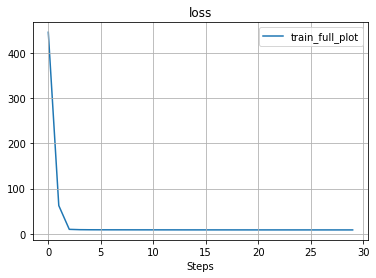

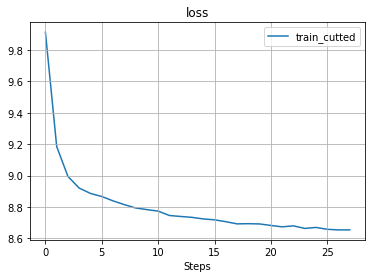

Train success


In [44]:
# функция обучения модели и вывода графика истории обучения
epoches = 30
def train(model, epochs, optimizer, criterion, train_loader, test_loader, device):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    all_train_losses = []
    validation_errors = []
    for e in tqdm(range(1, epoches+1)):
      train_loss_rmse = []
      model.train()
      for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred.float(), y_train_batch.unsqueeze(1).float())
        train_loss.backward()
        optimizer.step()
        train_loss_rmse.append(torch.sqrt(train_loss).detach().numpy())
      RMSE_scaled_train_loss = np.mean(train_loss_rmse) * y_scaler
      all_train_losses.append(RMSE_scaled_train_loss)
      print('Train loss:',  RMSE_scaled_train_loss)
    name = "train_full_plot"
    plot_history(all_train_losses, name)
    name = "train_cutted" # без первых двух записей ошибок, так как они очень большие и дальше не видно как падает ошибка 
    plot_history(all_train_losses[2:], name)
    return all_train_losses


print("Training started")
train(model, epoches, optimizer, criterion, train_loader, test_loader, device)
print("Train success")

In [45]:
def test(model, criterion, test_loader, device):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    y_pred_list = []
    with torch.no_grad():
      model.eval()
      for X_batch_test, y_batch_test in test_loader:
        X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)
        y_pred = model(X_batch_test) * y_scaler
        y_test = y_batch_test.unsqueeze(1).float() * y_scaler
        y_pred = y_pred.clone().detach()
        y_pred_list.append(y_pred)
    predicts = torch.cat(y_pred_list)
    return predicts

## Итоговая ошибка RMSE:

In [46]:
# смотрим качество по RMSE
y_pred_result_test = test(model, criterion, test_loader, device)
print(np.sqrt(mean_squared_error(y_pred_result_test, y_test * y_scaler)))

8.761421179782824


In [47]:
assert test(model, criterion, test_loader, device).shape[0] == y_test.shape[0]

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

# Эксперимент первый:
При подготовке датасета нормализовал входные данные с помощью MinMaxScaler. Батчи взял по 128. 
С самого начала решил не делать много слоев и ограничиться 3мя полносвязными. В качестве функции активации взял ReLU. В результате получилась сеть (90, 32) -> ReLU -> (16, 16) -> ReLU -> (16, 1). В конце единица, так как предсказываем единственную переменную -- год выхода песни. Оптимизатор использовал SGD и изменял там только learning_rate, однако данный набор средств не позволил получить ошибку RMSE на тесте меньше 15.

# Эксперимент второй
Во время второго эксперимента решил использовать больше нейронов и применить к каждому слою batchnorm, получил сеть "пошире": (90, 96) -> LeakyReLU -> (64, 32) -> LeakyReLU -> (32, 1), в которой число нейронов убывает слева направо. Также вместо обычного ReLU взял LeakyReLU, у которого при  x < 0, не ноль, а небольшое отрицательное значение (угловой коэффициент около 0,01), что помогает бороться с затухающим градиентом. Добавил параметры SGD weight_decay - регуляризатор, чтобы уберечь модель от переобучения под тестовую выборку и momentum (импульс) для корректировки точности шага обучения.
Далее опять начал перебирать параметры weight_decacy и learning_rate, а также batch_size. Уже более глубоко изучил документацию и пошерстил форумы, какие значения в каких зачах наиболее оптимальны. Благодаря более глубокому анализу теоретической части и увеличению количества гиперпараметров, пришел к следующему: learning_rate = 0,001, momentum = 0.89, weight_decay = 1e-4, batch_size = 128. 
При такой архитектуре удалось добиться качества 8.966 (ура, 4 балла как минимум в кармане). Но стало ясно, что при данной архитектуре и методах предобработки данных  как ни крути гиперпараметры, сильно меньше качество не получишь( Но тут пришла подсказка из чата в канале курса в телеграмме!!! И об этом будет третий эксперимент.

# Эксперимент третий
Действовать решил точно по подсказке -- ключом к успеху была нормировка выходных данных. Скейлить решил вручную -- взял самое большое значение "игрек" и на него поделил y_train и y_test. Потом в функциях train и test применил обратное масштабирование (домножил на scale), чтобы корректно считалось RMSE. Архитектуру самой нейросети оставил прежней -- три полносвязных слоя, лишь немного поменял количество нейронов (90, 128) -> LeakyReLU -> (128, 16) -> LeakyReLU -> (16, 1). По совету из телеграмма заменил SGD на Adam с learning_rate = 0.0003. Увеличил количество эпох до 30 и вот заветные 8.76 RMSE успешно показались в ячейке вывода программы. 